In [23]:
from skimage import (data, io, filters, data_dir, 
                     morphology, transform, img_as_ubyte)
from skimage.color import rgba2rgb, rgb2gray
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import re
from unicodedata import normalize
from openpyxl import load_workbook
import time
import pandas as pd
import datetime

In [24]:
def escalar(img):
    if (len(img[1])>1500 or len(img)>2000):
        img = transform.rescale(img, 4.0/5.0, multichannel=True)
        img = escalar(img)
    return img_as_ubyte(img)

def filtroColor(img):
    plt.imshow(img)
    plt.show()
    G=img[:,:,1]
    G=rgb2gray(G)/255.0
    imGray=rgb2gray(img)
    
    imResta=np.zeros((len(G),len(G[1,:])))
    
    for i in range (0,len(G)):
        for j in range (0,len(G[1,:])):
            imResta[i][j]=G[i][j]-imGray[i][j]
            if imResta[i][j] < 0:
                imResta[i][j] = 0
    
    imRel=filters.median(imResta)
    level=np.max(imRel)*0.32
    level=round(level)
    binary_local = imRel > level
    imFiltrada=morphology.remove_small_holes(binary_local)

    return imFiltrada

class segmentacion():
    def __init__(self, img):
        
        label_img = label(img)
        regions = regionprops(label_img)
        cY = []
        cX = []

        for i in range (0, len(regions)):
            y, x = regions[i].centroid
            cY.append(y)
            cX.append(x)

        pos = [i for i,x in enumerate(cX) if x==min(cX)]
        r1 = [ cY[pos[0]], cX[pos[0]]]
        cY.pop(pos[0])
        cX.pop(pos[0])

        pos = [i for i,x in enumerate(cX) if x==max(cX)]
        r2 = [ cY[pos[0]], cX[pos[0]]]
        cY.pop(pos[0])
        cX.pop(pos[0])

        r = [r1, r2]

        if r[0][0]==r[1][0]:
            R1=r1;
            R2=r2;

        else:
            rY=[r[0][0],r[1][0]]
            pos = [i for i,x in enumerate(rY) if x==min(rY)]
            R1 = r[pos[0]]
            pos = [i for i,x in enumerate(rY) if x==max(rY)]
            R2 = r[pos[0]]
        
        aux=np.array(R2)-np.array(R1)
        
        self.R1 = np.array(R1)
        self.R2 = np.array(R2)
        self.cY = np.array(cY)
        self.cX = np.array(cX)
        self.escala = 100.0 / np.sqrt((aux[0]**2+aux[1]**2))

def imgAjustar(img):
    
    imgR = filtroColor(img)
    R1 = segmentacion(imgR).R1
    R2 = segmentacion(imgR).R2
    
    ref = R2 - R1
    theta = np.arctan(ref[0]/ref[1])
    imRot = transform.rotate(img, theta*180.0/np.pi)
    
    aux = [R1[1], R2[1]]
    aux.sort()
    
    espace = np.sqrt((ref[0]**2+ref[1]**2)) / 10.0
    imAjustar = imRot[:, int(round(aux[0] - espace)) 
                      : int(round(aux[1] + espace))]
    imAjustar = img_as_ubyte(imAjustar)
    
    return imAjustar

def cuadricula(cx,cy,lx,ly,escala):
    
    x1=np.arange(cx, lx, escala)
    y1=np.arange(cy, ly, escala)
    [X1,Y1]=np.meshgrid(x1,y1)

    x2=np.arange(cx, 0, -escala)
    y2=np.arange(cy, 0, -escala)
    [X2,Y2]=np.meshgrid(x2,y2)

    x3=np.arange(cx, lx, escala)
    y3=np.arange(cy, 0, -escala)
    [X3,Y3]=np.meshgrid(x3,y3)

    x4=np.arange(cx, 0, -escala)
    y4=np.arange(cy, ly, escala)
    [X4,Y4]=np.meshgrid(x4,y4)

    [X,Y]=np.meshgrid(np.hstack((x1,x2,x3,x4)),
                      np.hstack((y1,y2,y3,y4)))
    
    Xh=np.hstack([X1[0,:],X2[0,:],X3[0,:],X4[0,:]])
    Yh=np.hstack([Y1[0,:],Y2[0,:],Y3[0,:],Y4[0,:]])

    Xv=np.hstack((X1[:,0],X2[:,0],X3[:,0],X4[:,0]))
    Yv=np.hstack((Y1[:,0],Y2[:,0],Y3[:,0],Y4[:,0]))

    return X, Y, Xh, Yh, Xv, Yv

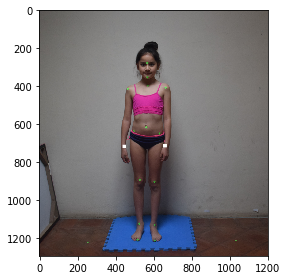

In [25]:
#Vista Anterior

image = io.imread('DSC_0376.jpg')
image = escalar(image)
io.imshow(image)
plt.show()

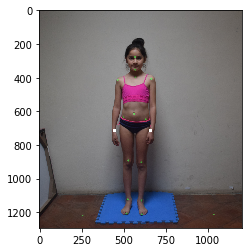

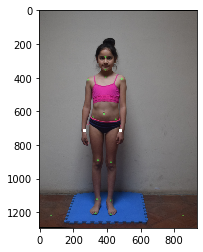

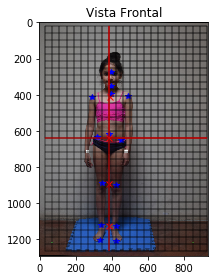

In [26]:
anterior=imgAjustar(image)

imgR = filtroColor(anterior)
R1 = segmentacion(imgR).R1
R2 = segmentacion(imgR).R2
cY = segmentacion(imgR).cY
cX = segmentacion(imgR).cX
e = segmentacion(imgR).escala

'''
F1 = Entrecejo
F2 = Mentón
F3 = Hombro derecho
F4 = Hombro izquierdo
F5 = Esternón
F6 = Ombligo
F7 = Perlvis derecha
F8 = Perlvis izquierda
F9 = Rodilla derecho
F10= Rodilla izquierda
F11= Tobillo derecho
F12= Tobillo izquierdo
F13= Dedo gordo derecho
F14= Dedo gordo izquierdo
FcH= Centro hombros
FcY= Centro en Y (Pelvis)
FcR= Centro rodillas
FcX= Centro en X (Tobillos)
FcP= Centro en dedos pies
'''
F1 = (cY[0], cX[0])
F2 = (cY[1], cX[1])

auxY = [cY[2], cY[3], cY[4]]
auxX = [cX[2], cX[3], cX[4]]
pos = [i for i,x in enumerate(auxX) if x==min(auxX)]
F3 = auxY[pos[0]], auxX[pos[0]]
auxY.pop(pos[0])
auxX.pop(pos[0])
pos = [i for i,x in enumerate(auxX) if x==max(auxX)]
F4 = auxY[pos[0]], auxX[pos[0]]
auxY.pop(pos[0])
auxX.pop(pos[0])
F5 = auxY[0],auxX[0]

auxY = [cY[5], cY[6], cY[7]]
auxX = [cX[5], cX[6], cX[7]]
pos = [i for i,x in enumerate(auxX) if x==min(auxX)]
F7 = auxY[pos[0]], auxX[pos[0]]
auxY.pop(pos[0])
auxX.pop(pos[0])
pos = [i for i,x in enumerate(auxX) if x==max(auxX)]
F8 = auxY[pos[0]], auxX[pos[0]]
auxY.pop(pos[0])
auxX.pop(pos[0])
F6 = auxY[0],auxX[0]

auxY = [cY[8], cY[9]]
auxX = [cX[8], cX[9]]
pos = [i for i,x in enumerate(auxX) if x==min(auxX)]
F9 = auxY[pos[0]], auxX[pos[0]]
pos = [i for i,x in enumerate(auxX) if x==max(auxX)]
F10 = auxY[pos[0]], auxX[pos[0]]

auxY = [cY[10], cY[11]]
auxX = [cX[10], cX[11]]
pos = [i for i,x in enumerate(auxX) if x==min(auxX)]
F11 = auxY[pos[0]], auxX[pos[0]]
pos = [i for i,x in enumerate(auxX) if x==max(auxX)]
F12 = auxY[pos[0]], auxX[pos[0]]

auxY = [cY[12], cY[13]]
auxX = [cX[12], cX[13]]
pos = [i for i,x in enumerate(auxX) if x==min(auxX)]
F13 = auxY[pos[0]], auxX[pos[0]]
pos = [i for i,x in enumerate(auxX) if x==max(auxX)]
F14 = auxY[pos[0]], auxX[pos[0]]

FcH= np.mean([F3,F4],axis=0)
FcY= np.mean([F7,F8],axis=0)
FcR= np.mean([F9,F10],axis=0)
FcX= np.mean([F11,F12],axis=0)
FcP= np.mean([F13,F14],axis=0)

F1 = np.array(F1)
F2 = np.array(F2)
F3 = np.array(F3)
F4 = np.array(F4)
F5 = np.array(F5)
F6 = np.array(F6)
F7 = np.array(F7)
F8 = np.array(F8)
F9 = np.array(F9)
F10= np.array(F10)
F11= np.array(F11)
F12= np.array(F12)
F13= np.array(F13)
F14= np.array(F14)

FcH= np.array(FcH)
FcY= np.array(FcY)
FcR= np.array(FcR)
FcX= np.array(FcX)
FcP= np.array(FcP)

plt.figure(1)
plt.title('Vista Frontal')

plt.plot(cX, cY,'b*')

plt.plot(FcH[1], FcH[0],'rx')
plt.plot(FcY[1], FcY[0],'rx')
plt.plot(FcR[1], FcR[0],'rx')
plt.plot(FcX[1], FcX[0],'rx')

aux=R2-R1
escala = np.sqrt((aux[0]**2+aux[1]**2)) / 20.0

cx = FcX[1]
cy = FcY[0]
lx = len(anterior[1])
ly = len(anterior)



(X, Y, Xh, Yh, Xv, Yv) = cuadricula(cx,cy,lx,ly,escala)

plt.plot(X,Y,'k',X.T,Y.T,'k',linewidth=0.1)
plt.plot(Xh,Yh,'r',linewidth=0.3)
plt.plot(Xv,Yv,'r',linewidth=0.3)

io.imshow(anterior)
plt.savefig('anterior.png', dpi = 200)
plt.show()

In [27]:
#Funciones de la vista Anterior

def T1P(X1,X2):
    
    X=X2-X1
    A=np.angle(complex(X[1],X[0]), deg=True)
    if A<-1.0:
        E='Der.'
    elif A>1.0:
        E='Izq.'
    else:
        E='Alin.'

    A=round(abs(A),1);
    
    return E, A

def T2F(X1,X2,E):

    Dis=(X1[1]-X2[1])*E;
    
    if Dis<-1.0:
        Dir='Izq.'
    elif Dis>1.0:
        Dir='Der.'
    else:
        Dir='Alin.'
    
    Dis=round(abs(Dis),1);
    
    return Dir, Dis

def T3F(X1,X2):

    X=X1-X2
    A=abs(np.angle(complex(X[1],X[0]), deg=True))
    
    if A>91.0:
        Dir='Rot.Ext.'
    elif A<89.0:
        Dir='Rot.Int.'
    else:
        Dir='Alin.'
        
    A=round(abs(A-90.0),1)
    
    return Dir, A

In [28]:
#TA1

resHombro1, angHombro = T1P(F3,F4)
resPelvis1, angPelvis = T1P(F7,F8)
resRodilla1, angRodilla = T1P(F9,F10)

datos=[['Hombros','Pelvis','Rodilla'],
       [resHombro1, resPelvis1, resRodilla1],
       [angHombro, angPelvis, angRodilla]]

dfTA1 = pd.DataFrame(datos,['Segmento Corporal', 
                            'Descendido', 'angulo'])
print (dfTA1.T)

#TA2

resFrente2, frente = T2F(FcX,F1,e);
resHombros2, hombros = T2F(FcX,FcH,e);
resOmbligo2, ombligo = T2F(FcX,F6,e);
resPelvis2, pelvis = T2F(FcX,FcY,e);
resRodillas2, rodillas = T2F(FcX,FcR,e);
resPies2, pies = T2F(FcX,FcP,e);

datos=[['Frente','Hombros','Ombligo',
        'Pelvis','Rodillas','Pies'],
       [resFrente2, resHombros2, resOmbligo2,
        resPelvis2, resRodillas2, resPies2],
       [frente, hombros, ombligo, pelvis,
        rodillas, pies]]

dfTA2 = pd.DataFrame(datos,['Referencia',
                            'Direccion','Distancia'])
print (dfTA2.T)

#TA3

resPieI, angPieI = T3F(F12,F14)
resPieD, angPieD = T3F(F13,F11)

datos=[['Pie Izquierdo','Pie Derecho'],
       [resPieI, resPieD],
       [angPieI, angPieD]]

dfTA3 = pd.DataFrame(datos,['Segmento Corporal',
                            'Direccion','Angulo'])
print (dfTA3.T)

  Segmento Corporal Descendido angulo
0           Hombros       Der.    1.3
1            Pelvis       Izq.    6.2
2           Rodilla       Izq.      8
  Referencia Direccion Distancia
0     Frente      Izq.       1.3
1    Hombros     Alin.       0.8
2    Ombligo     Alin.       0.2
3     Pelvis     Alin.       0.5
4   Rodillas     Alin.       0.5
5       Pies     Alin.       0.5
  Segmento Corporal Direccion Angulo
0     Pie Izquierdo     Alin.    0.6
1       Pie Derecho  Rot.Ext.    6.3


In [36]:
date = datetime.datetime.now()
fechaActual = (str(date.day)+'-'+str(date.month)
               +'-'+str(date.year))
fecha = fechaActual
nombre = 'Juan'
edad = 19
genero = 'M'
peso = 66.7
talla = 170
ocupacion = 'Est.'

n = pd.DataFrame([fecha,nombre,edad,genero,peso,talla,ocupacion],
                 ['Fecha','Nombre:','Edad:','Género:','Peso[kg]:','Talla[cm]:','Ocupación:'])

if os.path.exists('General.xlsx')==False:
    book = pd.ExcelWriter('General.xlsx')
    pd.DataFrame().to_excel(book, 'Anterior')
    pd.DataFrame().to_excel(book, 'Posterior')
    pd.DataFrame().to_excel(book, 'LateralD')
    book.save()
    
book = load_workbook('General.xlsx') 
    
writer = pd.ExcelWriter('General.xlsx', engine='openpyxl') 
writer.book = book 
writer.sheets = dict((ws.title, ws) for ws in book.worksheets) 

A1=pd.read_excel('General.xlsx', sheet_name=0)
nceldas=len(A1)
n.T.to_excel(writer,'Anterior',
                 header= True, index=False,startrow=nceldas+2, startcol=0)
dfTA1.T.to_excel(writer,'Anterior',
                 header= True, index=False,startrow=nceldas+4, startcol=0)
dfTA2.T.to_excel(writer,'Anterior',
                 header= True, index=False,startrow=nceldas+8, startcol=0)
dfTA3.T.to_excel(writer,'Anterior',
                 header= True, index=False,startrow=nceldas+15, startcol=0)
time.sleep(1)


A2=pd.read_excel('General.xlsx', sheet_name=1)
nceldas=len(A2)
n.T.to_excel(writer,'Posterior',
                 header= True, index=False,startrow=nceldas+2, startcol=0)
dfTA2.T.to_excel(writer,'Posterior',
                 header= True, index=False,startrow=nceldas+4, startcol=0)
time.sleep(1)

A3=pd.read_excel('General.xlsx', sheet_name=2)
nceldas=len(A3)
n.T.to_excel(writer,'LateralD',
                 header= True, index=False,startrow=nceldas+2, startcol=0)
dfTA3.T.to_excel(writer,'LateralD',
                 header= True, index=False,startrow=nceldas+4, startcol=0)
time.sleep(1)

writer.save()